In [230]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

clip = np.load(r'C:\Users\damig\MN\Projekt_alternatywny\ujecie_1_kz_pociete\atak z użyciem przedmiotu\atak-2022_11_23_10_38_55_2.npy')

In [231]:
# clip

clip

array([(1669196354420884,   2, 132, 1, 0, 0),
       (1669196354420884,  25, 474, 1, 0, 0),
       (1669196354420884,  89, 201, 0, 0, 0), ...,
       (1669196359420685, 609, 248, 1, 0, 0),
       (1669196359420685, 636, 231, 1, 0, 0),
       (1669196359420685, 636, 456, 1, 0, 0)],
      dtype=[('timestamp', '<i8'), ('x', '<i2'), ('y', '<i2'), ('polarity', 'i1'), ('_p1', '<i2'), ('_p2', 'i1')])

In [232]:
k = 1000000 # mikrosekund w sekundzie

In [233]:
agg = clip[clip['timestamp'] < clip['timestamp'][0] + 2*k]
agg = agg[agg['timestamp'] > agg['timestamp'][0] + 1 * k]

In [234]:
# 640 x 480
size = (480, 640)

In [235]:
canvas = np.zeros(size) + 0.5

In [236]:
for x, y, z in zip(agg['x'], agg['y'], agg['polarity']):
    if z == 1:
        canvas[y][x] += 1
    elif z == 0:
        canvas[y][x] -= 1

    #canvas[y][x] += 1

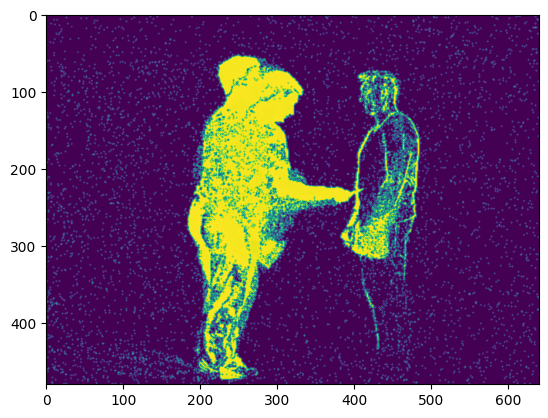

In [239]:
# normalizacja

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
img = (np.abs(canvas - 0.5) * 255).astype(np.uint8)
img = cv2.filter2D(img, -1, (1.0 / kernel.sum()) * kernel)

plt.imshow(img)

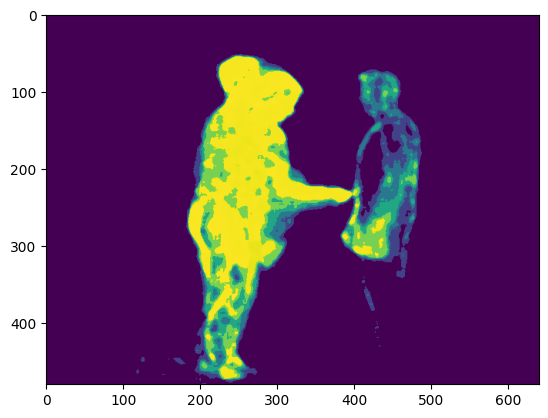

In [240]:
# odszumianie medianą

img = cv2.medianBlur(img, 9)

plt.imshow(img)

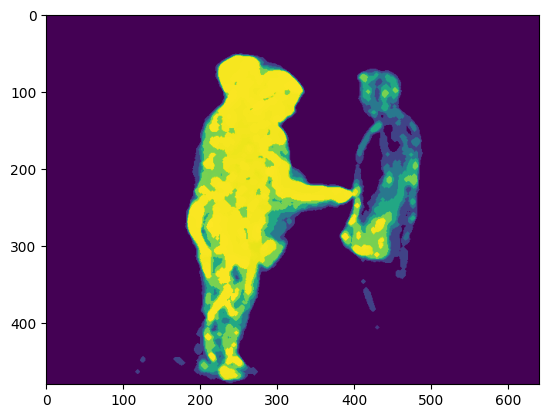

In [241]:
# morfologia

img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

img = cv2.dilate(img, kernel)

plt.imshow(img)

In [245]:
cv2.imshow('', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [262]:
def roi_bounding_box(roi_mask):
        x, y, width, height = cv2.boundingRect(roi_mask.astype(np.uint8))
        return x, y, width, height

In [265]:
def generate_roi(blobized_image, image, ratio_thr=0.5):
    count, obj = cv2.connectedComponents(blobized_image, connectivity=4)
    combined_mask = None
    for i in range(1, count):
        obj_mask = obj == i
        x, y, width, height = roi_bounding_box(obj_mask)
        # background = image.mean()
        # extracted = (image * obj_mask)[y : y + height, x : x + width] - background
        if (
            ((obj_mask.sum() / (width * height)) > ratio_thr)
            # and ((extracted.sum() / (width * height)) > (0.35 * ratio_thr))
            and (width >= (blobized_image.shape[1] * 0.1))
            and (height >= (blobized_image.shape[0] * 0.1))
        ):
            if combined_mask is None:
                combined_mask = obj_mask
            else:
                combined_mask += obj_mask
    return combined_mask

In [304]:
# BLOBING

# Apply thresholding
_, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Detect blobs
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 1
params.maxThreshold = 255

# Filter by Area.
params.filterByArea = True
params.minArea = 1

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(thresh)

pts = cv2.KeyPoint_convert(keypoints)

print(pts)

# Crop the image
x, y, h, w = cv2.boundingRect(pts)
cropped = img[y:y+h, x:x+w]

# # Create a mask
# mask = np.zeros(img.shape[:2], np.uint8)
# mask[y:y+h, x:x+w] = 255
#
# # Multiply the mask with the original image
# result = cv2.bitwise_and(img, img, mask=mask)

# Display the result
cv2.imshow("Result", cropped)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[250.      402.     ]
 [230.      387.     ]
 [396.      285.5    ]
 [203.5238  281.63492]
 [467.      203.     ]]


In [294]:
# skalowanie
x, y, h, w = cv2.boundingRect(pts)
x, y, h, w

# target resolution

# 1080 x 1980
# z kamery 480 x 640


# scaled_x = original_x * (new_resolution_width / old_resolution_width)
# scaled_y = original_y * (new_resolution_height / old_resolution_height)

scaled_x = int(203 * (1980 / 640))
scaled_y = int(203 * (1080 / 480 ))

scaled_h = int(265 * (1080 / 480))
scaled_w = int(200 * (1980 / 640))

In [295]:
scaled_x, scaled_y, scaled_h, scaled_w

(628, 456, 596, 618)

In [305]:
cap = cv2.VideoCapture(r'C:\Users\damig\MN\Projekt_alternatywny\ujecie_1_pociete\atak z użyciem przedmiotu\WIN_20221123_10_38_54_Pro._2.mp4')

cap.set(cv2.CAP_PROP_POS_MSEC, 2500)

# Read the frame
success, frame = cap.read()

cropped = frame[scaled_y:scaled_y+scaled_h, scaled_x :scaled_x +scaled_w]

# Create a mask
# mask = np.zeros(frame.shape[:2], np.uint8)
# mask[scaled_y:scaled_y+scaled_h, scaled_x:scaled_x+scaled_w] = 255
#
# # Multiply the mask with the original image
# result = cv2.bitwise_and(frame, frame, mask=mask)

# resized = cv2.resize(cropped, (64, 64))

# Display the result
cv2.imshow("Result", cropped)
cv2.waitKey(0)
cv2.destroyAllWindows()

# # Display the result
# cv2.imshow("Result", frame)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Release the video
cap.release()

In [116]:
def aggregate(clip, duration, size=(480, 640)):
    """

    :param clip:
    :param duration:
    :param size:
    :return:
    """

    k = 1000000 # mikrosekund w sekundzie

    images = []

    start = clip['timestamp'][0]

    for i in range(1, duration + 1):
        image = np.zeros(size)
        agg = clip[clip['timestamp'] < start + i * duration * k]
        for x, y, z in zip(agg['x'], agg['y'], agg['polarity']):
            canvas[y][x] = z

        start = start + duration * i * k